## Analysis

This notebook contains the code for the analysis of the final dataset. While rigorous econometric analysis is limited to basic stationarity tests (due to the nature of the dataset), some basic tests for market efficiency can reveal a lot of insight as to how the machine learning traders affected the market.

The tests we will conduct will look at a variety of factors, including mean-reversion tendencies, run tests and whether our different types of traders outperformed some simple strategies such as filters and buy-and-hold strategies. We will also perform tests for stationarity and cointegration (between the fundamental price and trading price) although again these should be taken with a grain of salt, as the price series have been generated by our simulations rather than a true random process.

In [135]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import csv
import glob
from tqdm import tqdm
import statsmodels.tsa.stattools as sm
import collections

In [136]:
def unpack_data(filepath): #Returns a dictionary where each item is a df containing one run, one dict per generation
    all_files = glob.glob(filepath + "/*.csv")
    name_list = []
    datadict = {}
    for f in all_files:
        name_list.append(f[89:-4])
    for i,n in enumerate(name_list):
        datadict[n] = pd.read_csv(all_files[i], header=0)
#    for k, v in datadict.items():
#        v.drop(columns=["Unnamed: 0", "volume", "spread", "10_MA", "50_MA"], inplace=True)
    return datadict

In [130]:
gendict = {}
for i in tqdm(range(51)):
    genname = i
    gendict[genname] = unpack_data(f"/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/simulations/gen{i}_sims/data")

100%|██████████| 51/51 [00:13<00:00,  3.75it/s]


In [126]:
def order_dict(datadict): #Takes a dictionary of data and returns an ordered dictionary
    ordered_dict = collections.OrderedDict(sorted(datadict.items()))
    return ordered_dict

In [17]:
gens = np.array([i for i in range(51)])

In [134]:
def compute_mean_squared_diff(datadict): #Returns average mean squared difference, i.e. the square of the average distance between the true price and trading price for any given period in any given simlation
    msd_list = []
    for k, v in datadict.items():
        diff_list = []
        for i in range(len(v)):
            squared_diff = (v.iloc[i]["trading_price"] - v.iloc[i]["true_price"])**2
            diff_list.append(squared_diff)
        msd = sum(diff_list)/len(diff_list)
        msd_list.append(msd) 
    avg_msd = sum(msd_list)/len(msd_list)
    return avg_msd

def gen_msd(gendict): #Computes mean squared difference for all generations and returns a np array with them all
    msd_list = []
    for k, v in gendict.items():
        msd = compute_mean_squared_diff(v)
        msd_list.append(msd)
    msd_array = np.array(msd_list)
    return msd_array

In [20]:
def compute_reversion_rate(datadict, dev=1): #For any given run of the market, how many times does price deviate and how long does it take to return to the true price
    final_avg_return_list = [] #Avg returned run length for individual simulations
    final_avg_no_return_list = [] #Avg run length for not returned runs for individual simulations
    return_run_length_list = [] #Number of deviations per simulation that return for individual simulations
    no_return_run_length_list = [] #Number of deviations per simulation that don't return for individual simulations
    for k, v in datadict.items():
        run_count = 0
        dev_return_list = []
        dev_no_return_list = []
        for i in range(len(v)):
            if abs(v.iloc[i]["trading_price"] - v.iloc[i]["true_price"]) > dev and abs(v.iloc[i-1]["trading_price"] - v.iloc[i-1]["true_price"]) <= dev:
                for t in range(i, len(v)):
                    if abs(v.iloc[t]["trading_price"] - v.iloc[t]["true_price"]) > dev and t == len(v)-1:
                        dev_no_return_list.append(t-i)
                        break
                    elif abs(v.iloc[t]["trading_price"] - v.iloc[t]["true_price"]) <= dev:
                        dev_return_list.append(t-i)
                        break        
        if len(dev_return_list) != 0:
            avg_return_time = sum(dev_return_list)/len(dev_return_list)
            final_avg_return_list.append(avg_return_time)
            return_run_length_list.append(len(dev_return_list))
        if len(dev_no_return_list) != 0:
            avg_no_return_time = sum(dev_no_return_list)/len(dev_no_return_list)
            final_avg_no_return_list.append(avg_no_return_time)
            no_return_run_length_list.append(len(dev_no_return_list))
    final_avg_return = sum(final_avg_return_list)/len(final_avg_return_list) #Length of avg deviation run (that returned)
    final_avg_no_return = sum(final_avg_no_return_list)/len(final_avg_no_return_list) #Length of avg deviation run (that didn't return)
    avg_no_returns = sum(return_run_length_list)/len(datadict) #Avg number of deviations per run that returned
    avg_no_no_returns = sum(no_return_run_length_list)/len(datadict) #Avg number of deviations per run that didn't return
    return final_avg_return, final_avg_no_return, avg_no_returns, avg_no_no_returns

def reversion_stats(gendict):
    returned_run_length_list = []
    unreturned_run_length_list = []
    returned_devs_per_run_list = []
    unreturned_devs_per_run_list = []
    for k, v in gendict.items():
        rrl, url, rdpr, udpr = compute_reversion_rate(v)
        returned_run_length_list.append(rrl)
        unreturned_run_length_list.append(url)
        returned_devs_per_run_list.append(rdpr)
        unreturned_devs_per_run_list.append(udpr)
    returned_run_length_array = np.array(returned_run_length_list)
    unreturned_run_length_array = np.array(unreturned_run_length_list)
    returned_devs_per_run_array = np.array(returned_devs_per_run_list)
    unreturned_devs_per_run_array = np.array(unreturned_devs_per_run_list)
    return returned_run_length_array, unreturned_run_length_array, returned_devs_per_run_array, unreturned_devs_per_run_array

In [25]:
def compute_inefficient_proportion(datadict, dev=1): #Computes the proportion of time that the true and trading prices deviate
    prop_list = []
    for k, v in datadict.items():
        prop_temp = 0
        for i in range(len(v)):
            if abs(v.iloc[i]["trading_price"] - v.iloc[i]["true_price"]) > dev:
                prop_temp +=1
        prop_list.append((prop_temp/len(v)))
    prop = sum(prop_list)/len(prop_list)
    return prop

def inefficient_proportion(gendict):
    ineff_list = []
    for k, v in gendict.items():
        ineff = compute_inefficient_proportion(v)
        ineff_list.append(ineff)
    ineff_array = np.array(ineff_list)
    return ineff_array

In [35]:
def compute_volatility(datadict): #Computes the average volatility for a generation of data
    vol_list = []
    for k, v in datadict.items():
        price_array = v["trading_price"].to_numpy(copy=True)
        vol = np.std(price_array)
        vol_list.append(vol)
    vol_array = np.array(vol_list)
    avg_vol = np.mean(vol_array)
    return avg_vol

def volatility(gendict):
    vol_list = []
    for k, v in gendict.items():
        vol = compute_volatility(v)
        vol_list.append(vol)
    vol_array = np.array(vol_list)
    return vol_array

In [64]:
def compute_stationarity(datadict, p=0.01): #Computes the proportion of a generation that has stationary data
    stat_count = 0
    total_count = 0
    for k, v in datadict.items():
        price_array = v["trading_price"].to_numpy(copy=True)
        try:
            _, pval, _, _, _, _ = sm.adfuller(price_array, regression="ct")
            if pval < p:
                stat_count += 1
            total_count += 1
        except ValueError:
            pass
    stat_prop = stat_count/total_count
    return stat_prop

def stationary_proportion(gendict, pcrit=0.01):
    stat_list = []
    for k, v in gendict.items():
        stat_prop = compute_stationarity(v, pcrit)
        stat_list.append(stat_prop)
#        print(stat_prop)
    stat_array = np.array(stat_list)
    return stat_array

In [72]:
def compute_coint_proportion(datadict, p=0.01): #Computes the proportion of a generation where both price series are cointegrated
    coint_count = 0
    total_count = 0
    for k, v in datadict.items():
        price_array = v["trading_price"].to_numpy(copy=True)
        true_array = v["true_price"].to_numpy(copy=True)
        try:
            _, pval, _ = sm.coint(price_array, true_array, trend="nc")
            if pval < p:
                coint_count += 1
            total_count += 1
        except ValueError:
            pass
    coint_prop = coint_count/total_count
    return coint_prop

def cointegrated_proportion(gendict, pcrit=0.01):
    coint_list = []
    for k, v in gendict.items():
        coint_prop = compute_coint_proportion(v, pcrit)
        coint_list.append(coint_prop)
    coint_array = np.array(coint_list)
    return coint_array

In [152]:
def compute_avg_spread(datadict): #Computes the average spread for a generation
    spread_list = []
    for k, v in datadict.items():
        spread = v["spread"].to_numpy(copy=True)
        spread_list.append(np.mean(spread))
    spread_array = np.array(spread_list)
    avg_spread = np.mean(spread_array)
    return avg_spread
    
def avg_spread(gendict):
    spread_list = []
    for k, v in gendict.items():
        avg_spread = compute_avg_spread(v)
        spread_list.append(avg_spread)
    spread_array = np.array(spread_list)
    return spread_array

In [183]:
def compute_avg_volume(datadict): #Computes avergage volume for a generation
    vol_list = []
    for k, v in datadict.items():
        vol = v["volume"].to_numpy(copy=True)
        vol_list.append(np.mean(vol))
    vol_array = np.array(vol_list)
    avg_vol = np.mean(vol_array)
    return avg_vol

def avg_vol(gendict):
    vol_list = []
    for k, v in gendict.items():
        avg_vol = compute_avg_volume(v)
        vol_list.append(avg_vol)
    vol_array = np.array(vol_list)
    return vol_array

In [137]:
msd = gen_msd(gendict)
avg_ret_run, avg_unret_run, no_ret_runs, no_unret_runs = reversion_stats(gendict)
ineff_prop = inefficient_proportion(gendict)
vol = volatility(gendict)
stationary1 = stationary_proportion(gendict)
stationary5 = stationary_proportion(gendict, 0.05)
stationary10 = stationary_proportion(gendict, 0.1)
coint1 = cointegrated_proportion(gendict)
coint5 = cointegrated_proportion(gendict, 0.05)
coint10 = cointegrated_proportion(gendict, 0.1)
spread = avg_spread(gendict)

In [184]:
volume = avg_vol(gendict)

In [185]:
gendata = pd.DataFrame(data={"volatility": vol,
                             "volume": volume,
                             "stat_prop1": stationary1,
                             "stat_prop5": stationary5,
                             "stat_prop10": stationary10,
                             "coint_prop1": coint1,
                             "coint_prop5": coint5,
                             "coint_prop10": coint10,
                             "spread": spread,
                             "msd": msd,
                             "ineff_prop": ineff_prop,
                             "avg_ret_run": avg_ret_run,
                             "avg_unret_run": avg_unret_run,
                             "no_ret_runs": no_ret_runs,
                             "no_unret_runs": no_unret_runs}
                       , index=gens)

In [186]:
gendata

,volatility,volume,stat_prop1,stat_prop5,stat_prop10,coint_prop1,coint_prop5,coint_prop10,spread,msd,ineff_prop,avg_ret_run,avg_unret_run,no_ret_runs,no_unret_runs
0,11.300414,22.964998,0.090000,0.160000,0.210000,0.320000,0.390000,0.480000,1.738130,277.890478,0.524213,4.961648,149.509804,23.280000,0.510000
1,10.541052,23.690633,0.060606,0.121212,0.202020,0.380000,0.450000,0.530000,1.802771,350.780214,0.462623,2.827539,172.372093,22.000000,0.430000
2,11.934356,23.742956,0.050000,0.150000,0.290000,0.350000,0.440000,0.470000,1.861403,486.561322,0.573715,3.913670,214.285714,19.900000,0.560000
3,11.958965,25.017446,0.020000,0.070000,0.110000,0.390000,0.500000,0.540000,1.828283,572.121252,0.487853,3.427061,175.795918,22.100000,0.490000
4,14.507198,23.072521,0.060606,0.121212,0.141414,0.320000,0.380000,0.400000,2.157732,1125.467042,0.565592,4.738985,222.305085,22.210000,0.590000
5,11.990094,23.454980,0.020000,0.060000,0.120000,0.290000,0.430000,0.470000,1.897187,738.260825,0.509428,4.305023,162.423077,24.180000,0.520000
6,13.851674,23.420274,0.030303,0.050505,0.070707,0.353535,0.393939,0.454545,1.905142,817.421288,0.535043,3.711120,213.560000,22.212121,0.505051
7,12.335947,25.767300,0.020000,0.080000,0.100000,0.370000,0.430000,0.480000,1.843119,318.376108,0.495756,4.919995,120.784314,26.890000,0.510000
8,12.878311,24.805830,0.030000,0.100000,0.160000,0.340000,0.410000,0.450000,1.875712,816.928805,0.533675,4.928416,183.166667,21.890000,0.480000
9,13.815856,25.060196,0.030303,0.090909,0.111111,0.420000,0.520000,0.550000,1.882398,802.128704,0.448730,2.589557,153.156863,27.790000,0.510000


-8.18358564279713
761.3740193384618


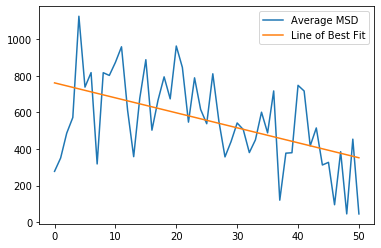

In [161]:
plt.plot(gendata.index, gendata["msd"], label="Average MSD")
m, b = np.polyfit(gendata.index, gendata["msd"], 1)
plt.plot(gendata.index, m*gendata.index + b, label="Line of Best Fit")
plt.legend()
print(m)
print(b)

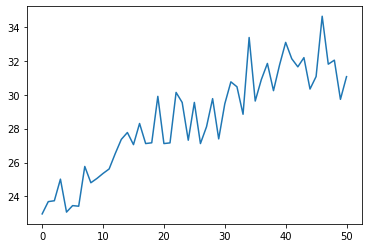

In [187]:
plt.plot(gendata.index, gendata["volume"])

In [91]:
def unpack_states(filepath): #Slightly modified function for unpacking the states data rather than run data
    all_files = glob.glob(filepath + "*.csv")
    name_list = []
    datadict = {}
    for f in all_files:
        name_list.append(f[91:-4])
    for i,n in enumerate(name_list):
        datadict[n] = pd.read_csv(all_files[i], header=0)
#    for k, v in datadict.items():
#        v.drop(columns=["Unnamed: 0", "volume", "spread", "10_MA", "50_MA"], inplace=True)
    return datadict

In [96]:
fsdict = {}
for i in tqdm(range(51)):
    fsname = f"gen{i}"
    fsdict[fsname] = unpack_states(f"/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/simulations/gen{i}_sims/states/final")    

100%|██████████| 51/51 [00:14<00:00,  3.64it/s]


In [99]:
isdict = {}
for i in tqdm(range(51)):
    isname = f"gen{i}"
    isdict[isname] = unpack_states(f"/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/simulations/gen{i}_sims/states/state0")    

100%|██████████| 51/51 [00:12<00:00,  4.02it/s]


In [168]:
def dom_flavour(fsdatadict): #Returns a dictionary of the count of the top flavour for each run within a generation
    toparb = 0
    topchart = 0
    topval = 0
    topnoise = 0
    toplstm = 0
    for k, v in fsdatadict.items():
        arbcount = 0
        chartcount = 0
        valcount = 0
        noisecount = 0
        lstmcount = 0
        for i in range(len(v)):
            if v.iloc[i]["flavour"] == "arb":
                arbcount += 1
            elif v.iloc[i]["flavour"] == "chart":
                chartcount += 1
            elif v.iloc[i]["flavour"] == "val":
                valcount += 1
            elif v.iloc[i]["flavour"] == "noise":
                noisecount += 1
            elif v.iloc[i]["flavour"] == "lstm":
                lstmcount += 1
        countdict = {arbcount: "arb", chartcount: "chart", valcount: "val", noisecount: "noise", lstmcount: "lstm"}
        topflavour = countdict.get(max(countdict))
        if topflavour == "arb":
            toparb += 1
        elif topflavour == "chart":
            topchart += 1
        elif topflavour == "val":
            topval += 1
        elif topflavour == "noise":
            topnoise += 1
        elif topflavour == "lstm":
            toplstm += 1
    topflavourdict = {"arb": toparb, "chart": topchart, "val":topval, "noise": topnoise, "lstm": toplstm}
    return topflavourdict

def dom_flavour_all(fsdict):
    listoftopdicts = []
    for k, v in fsdict.items():
        topflavour = dom_flavour(v)
        listoftopdicts.append(topflavour)
    return listoftopdicts

def top_flavour_arrays(toplist):
    arbtop = []
    charttop = []
    valtop = []
    noisetop = []
    lstmtop = []
    for i in toplist:
        arbtop.append(i["arb"])
        charttop.append(i["chart"])
        valtop.append(i["val"])
        noisetop.append(i["noise"])
        lstmtop.append(i["lstm"])
    arbarray = np.array(arbtop)
    chartarray = np.array(charttop)
    valarray = np.array(valtop)
    noisearray = np.array(noisetop)
    lstmarray = np.array(lstmtop)
    return arbarray, chartarray, valarray, noisearray, lstmarray

In [110]:
topflavourslist = dom_flavour_all(fsdict)

In [170]:
arbtop, charttop, valtop, noisetop, lstmtop = top_flavour_arrays(topflavourslist)

In [173]:
proportion_data = pd.DataFrame(data={"arbtop": arbtop,
                               "charttop": charttop,
                               "valtop": valtop,
                               "noisetop": noisetop,
                               "lstmtop": lstmtop}, index=gens)

In [174]:
proportion_data

,arbtop,charttop,valtop,noisetop,lstmtop
0,61,19,19,1,0
1,64,21,14,1,0
2,52,24,23,1,0
3,63,22,13,2,0
4,50,32,18,0,0
5,59,26,15,0,0
6,59,25,14,1,0
7,64,14,21,1,0
8,56,23,19,2,0
9,66,19,13,2,0


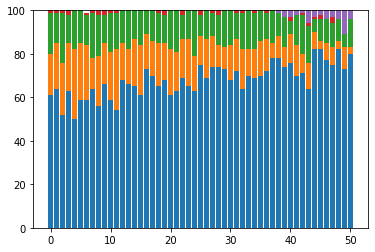

In [178]:
#p1 = plt.bar(statesdata.index, arbtop)
#p2 = plt.bar(statesdata.index, charttop, bottom=arbtop)
#p3 = plt.bar(statesdata.index, valtop, bottom=arbtop+charttop)
#p4 = plt.bar(statesdata.index, noisetop, bottom=arbtop+charttop+valtop)
#p5 = plt.bar(statesdata.index, lstmtop, bottom=arbtop+charttop+valtop+noisetop)

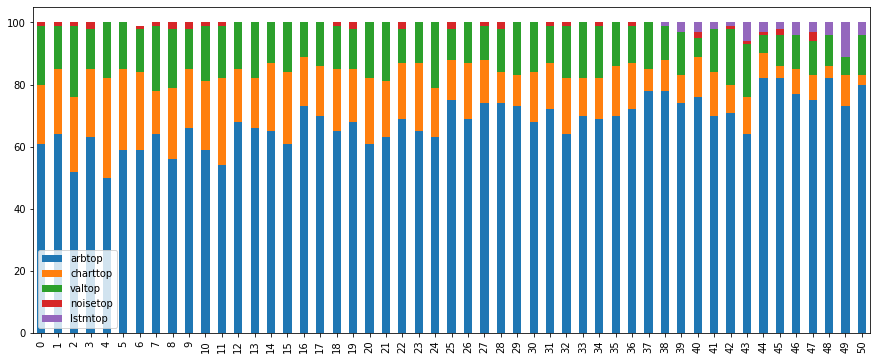

In [180]:
ax = proportion_data.plot(kind="bar", stacked=True, figsize=(15, 6))

In [188]:
def compute_top_earner(fsdatadict): #Records flavour of top earner from each market run
    arbtop = 0
    charttop = 0
    valtop = 0
    noisetop = 0
    lstmtop = 0
    for k, v in fsdatadict.items():
        sortedv = v.sort_values(by=["acc"], ascending=False)
        topflavour = sortedv.iloc[0]["flavour"]
        if topflavour == "arb":
            arbtop += 1
        elif topflavour == "chart":
            charttop += 1
        elif topflavour == "val":
            valtop += 1
        elif topflavour == "noise":
            noisetop += 1
        elif topflavour == "lstm":
            lstmtop += 1
    topflavours = {"arb": arbtop, "chart": charttop, "val": valtop, "noise": noisetop, "lstm": lstmtop}
    return topflavours

def top_earner(fsdict):
    topflavourslist = []
    for k, v in fsdict.items():
        top_earner = compute_top_earner(v)
        topflavourslist.append(top_earner)
    return topflavourslist

In [190]:
topearnerslist = top_earner(fsdict)
arbbest, chartbest, valbest, noisebest, lstmbest = top_flavour_arrays(topearnerslist)

In [191]:
earning_data = pd.DataFrame(data={"arbbest": arbbest,
                               "chartbest": chartbest,
                               "valbest": valbest,
                               "noisebest": noisebest,
                               "lstmbest": lstmbest}, index=gens)

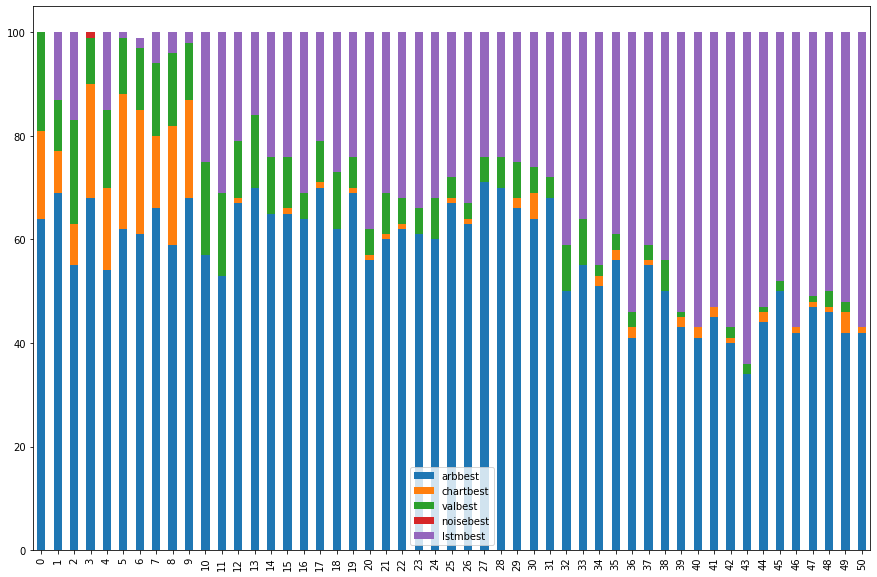

In [193]:
earning_ax = earning_data.plot(kind="bar", stacked=True, figsize=(15, 10))

In [ ]:
# Check how many times the top earner was the newest LSTM and how many times it was a previous LSTM and 
# how adding a new LSTM affects the behaviour of previous LSTMs